In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.amp as amp
import numpy as np

In [34]:
# Setting up Device Config
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")


Using Device: cuda


In [35]:
torch.manual_seed(42)
transform= transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std of MNIST
])
# Create train and test datasets
train_dataset= torchvision.datasets.MNIST(
    root='./data',
    train= True,
    download= True,
    transform= transform
)
test_dataset= torchvision.datasets.MNIST(
    root= './data',
    train= False,
    download= True,
    transform= transform
)

# Setup dataloaders with batch size
batch_size= 128
train_loader= torch.utils.data.DataLoader(
    dataset= train_dataset,
    batch_size= batch_size,
    shuffle= True
)

test_loader= torch.utils.data.DataLoader(
    dataset= test_dataset,
    batch_size= batch_size,
    shuffle= False
)

print(f"Training dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Training dataset size: 60000 samples
Test dataset size: 10000 samples
Number of batches in train loader: 469
Number of batches in test loader: 79


Text(0.5, 1.0, 'Ground Truth: 3')

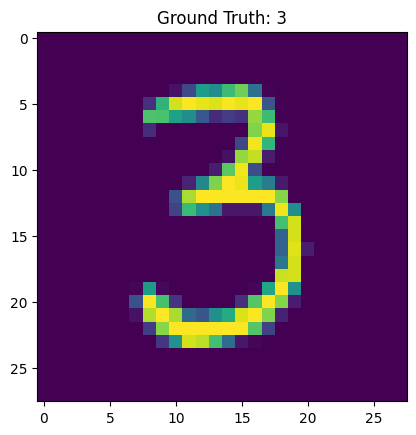

In [36]:
sample_image= train_dataset[50][0].squeeze()
sample_label= train_dataset[50][1]
plt.imshow(sample_image)

plt.title(f"Ground Truth: {sample_label}")

In [37]:
class TinyMLP(nn.Module):
    def __init__(self):
        super(TinyMLP, self).__init__()

        # Input Layer
        self.fc1= nn.Linear(784, 128) # Input flattened 28x28 images (784) -> Output (128)
        # First hidden layer
        self.fc2= nn.Linear(128, 64) # (Input: 128, Output: 64)
        self.fc3= nn.Linear(64, 10) # (Input: 64, Output: 10) output Corresponds to num of classes  
        self.relu= nn.ReLU()

    def forward(self, x):
        # Flatten input image (batch_size, 1, 28, 28) to (batch_size, 784)
        x= x.view(-1, 784)
        # Forward pass through the network
        x= self.relu(self.fc1(x)) # Apply ReLU after first linear layer
        x= self.relu(self.fc2(x)) # Apply ReLU after second linear layer
        x= self.fc3(x) # Output layer (no activation here as we'll use CE Loss)
        
        return x

In [38]:
def numerically_stable_cross_entropy(logits, targets):
    # Implement log-sum-exp trick
    max_logits= torch.max(logits, dim= 1, keepdim= True).values
    log_sum_exp= max_logits + torch.log(torch.sum(torch.exp(logits - max_logits), dim= 1, keepdim= True))
    log_softmax= logits - log_sum_exp
    loss= -log_softmax.gather(1, targets.unsqueeze(1)).mean()
    return loss

In [39]:
def compare_libCE_customCE(custom_ce, lib_ce):
    return lib_ce - custom_ce

In [40]:
def train_amp(model,
            train_loader,
            test_loader,
            custom_ce_loss,
            lib_ce_loss,
            optimizer,
            num_epochs= 10):
    # Initializing history dict to track metrics
    history= {
        'my_train_loss': [],
        'ptrch_train_loss': [],
        'train_acc': [],
        'my_test_loss': [],
        'test_acc': [],
        'ptrch_test_loss': [],
        'epoch_time': []
    }
    # Moving model to configured device 
    model = model.to(device)

    # Initialize GradScaler for AMP
    scaler= amp.GradScaler(device= 'cuda')
    for epoch in range (num_epochs):
        model.train() # Set model to training mode
        my_running_loss= 0.0
        ptrch_running_loss= 0.0
        correct= 0
        total= 0
        
        # Start timer for epoch
        start_time= time.time()

        for images, labels in train_loader:
            # Move Data to device
            images, labels= images.to(device), labels.to(device)
            
            # Zero parameter gradients
            optimizer.zero_grad()
            
            # Use autocast context for forward pass 
            with amp.autocast(device_type= 'cuda'):
                outputs= model(images)
                my_ce_loss= custom_ce_loss(outputs, labels)
                ptrch_ce_loss= lib_ce_loss(outputs, labels)
            
            # Scale loss and call backward
            scaler.scale(my_ce_loss).backward()

            # Unscale gradients and call optimizer step
            scaler.step(optimizer)

            # Update scaler for next iteration
            scaler.update()
            # Track statistics
            my_running_loss+= my_ce_loss.item()
            ptrch_running_loss+= ptrch_ce_loss.item() 
            _, predicted= torch.max(outputs.data, 1)
            total+= labels.size(0)
            correct+= (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_time= time.time() - start_time
        my_train_loss= my_running_loss / len(train_loader)
        ptrch_train_loss= ptrch_running_loss / len(train_loader)
        train_acc= 100. * correct / total

        # Evaluate on test set
        model.eval() # Set model to eval mode
        my_test_loss= 0.0
        ptrch_test_loss= 0.0
        test_correct= 0
        test_total= 0

        with torch.no_grad(): # Disable gradient calculation
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)

                with amp.autocast(device_type= 'cuda'):
                    outputs= model(images)
                    my_loss= custom_ce_loss(outputs, labels)
                    ptrch_loss= lib_ce_loss(outputs, labels)
                    
                my_test_loss+= my_loss.item()
                ptrch_test_loss+= ptrch_loss.item()
                _, predicted= torch.max(outputs.data, 1)

                test_total+= labels.size(0)
                test_correct+= (predicted == labels).sum().item()
            
        my_test_loss= my_test_loss / len(test_loader)
        ptrch_test_loss= ptrch_test_loss / len(test_loader)
        test_acc= 100. * test_correct / test_total

        # Store metrics history
        history['my_train_loss'].append(my_train_loss)
        history['ptrch_train_loss'].append(ptrch_train_loss)
        history['train_acc'].append(train_acc)
        history['my_test_loss'].append(my_test_loss)
        history['test_acc'].append(test_acc)
        history['ptrch_test_loss'].append(ptrch_test_loss)
        history['epoch_time'].append(epoch_time)

        # Print Epoch Summary
        print(f'Epoch [{epoch + 1}/{num_epochs}], ')
        print(f'Time: {epoch_time:.2f}s, ')
        print(f'Custom CE Train Loss: {my_train_loss:.8f}, ')
        print(f'Library CE Train Loss: {ptrch_train_loss:.8f}, ')
        print(f'Train Accuracy: {train_acc:.2f}%, ')
        print(f'Custom CE Test Loss: {my_test_loss:.8f}, ')
        print(f'Library CE Test Loss: {ptrch_test_loss:.8f}, ')
        print(f'Test Accuracy: {test_acc:.2f}%')
        print('-'*50)
    return history

In [41]:
torch.manual_seed(42)
model_amp= TinyMLP()
lib_ce= nn.CrossEntropyLoss()
optimizer= optim.Adam(model_amp.parameters(), lr= 0.001)
history_amp= train_amp(model= model_amp,
              train_loader= train_loader,
              test_loader= test_loader,
              custom_ce_loss= numerically_stable_cross_entropy,
              lib_ce_loss= lib_ce,
              optimizer= optimizer)

Epoch [1/10], 
Time: 3.34s, 
Custom CE Train Loss: 0.31509094, 
Library CE Train Loss: 0.31509025, 
Train Accuracy: 90.82%, 
Custom CE Test Loss: 0.14737192, 
Library CE Test Loss: 0.14737219, 
Test Accuracy: 95.50%
--------------------------------------------------
Epoch [2/10], 
Time: 3.32s, 
Custom CE Train Loss: 0.12609508, 
Library CE Train Loss: 0.12609488, 
Train Accuracy: 96.19%, 
Custom CE Test Loss: 0.10957817, 
Library CE Test Loss: 0.10957818, 
Test Accuracy: 96.59%
--------------------------------------------------
Epoch [3/10], 
Time: 3.30s, 
Custom CE Train Loss: 0.08828160, 
Library CE Train Loss: 0.08828230, 
Train Accuracy: 97.29%, 
Custom CE Test Loss: 0.09782381, 
Library CE Test Loss: 0.09782527, 
Test Accuracy: 96.87%
--------------------------------------------------
Epoch [4/10], 
Time: 3.34s, 
Custom CE Train Loss: 0.06709796, 
Library CE Train Loss: 0.06709777, 
Train Accuracy: 97.90%, 
Custom CE Test Loss: 0.08445358, 
Library CE Test Loss: 0.08445322, 
Test 

In [42]:
def train_float32(model,
                       train_loader,
                       test_loader,
                       custom_ce_loss,
                       lib_ce_loss,
                       optimizer,
                       num_epochs= 10):
    # Initializing history dict to track metrics
    history= {
        'my_train_loss': [],
        'ptrch_train_loss': [],
        'train_acc': [],
        'my_test_loss': [],
        'ptrch_test_loss': [],
        'test_acc': [],
        'epoch_time': []
    }
    # Moving model to configured device 
    model = model.to(device)

    for epoch in range (num_epochs):
        model.train() # Set model to training mode
        my_running_loss= 0.0
        ptrch_running_loss= 0.0
        correct= 0
        total= 0
        
        # Start timer for epoch
        start_time= time.time()

        for images, labels in train_loader:
            # Move Data to device
            images, labels= images.to(device), labels.to(device)
            
            # Zero parameter gradients
            optimizer.zero_grad()
            
            # Forward 
            outputs= model(images)
            my_ce_loss= custom_ce_loss(outputs, labels)
            ptrch_ce_loss= lib_ce_loss(outputs, labels)
            
            # Backward and optimizer step
            my_ce_loss.backward()
            optimizer.step()

            # Track statistics
            my_running_loss+= my_ce_loss.item()
            ptrch_running_loss+= ptrch_ce_loss.item() 
            _, predicted= torch.max(outputs.data, 1)
            total+= labels.size(0)
            correct+= (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_time= time.time() - start_time
        my_train_loss= my_running_loss / len(train_loader)
        ptrch_train_loss= ptrch_running_loss / len(train_loader)
        train_acc= 100. * correct / total

        # Evaluate on test set
        model.eval() # Set model to eval mode
        my_test_loss= 0.0
        ptrch_test_loss= 0.0
        test_correct= 0
        test_total= 0

        with torch.no_grad(): # Disable gradient calculation
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)

                outputs= model(images)
                my_loss= custom_ce_loss(outputs, labels)
                ptrch_loss= lib_ce_loss(outputs, labels)
                my_test_loss+= my_loss.item()
                ptrch_test_loss+= ptrch_loss.item()
                _, predicted= torch.max(outputs.data, 1)

                test_total+= labels.size(0)
                test_correct+= (predicted == labels).sum().item()
            
        my_test_loss= my_test_loss / len(test_loader)
        ptrch_test_loss= ptrch_test_loss / len(test_loader)
        test_acc= 100. * test_correct / test_total

        # Store metrics history
        history['my_train_loss'].append(my_train_loss)
        history['ptrch_train_loss'].append(ptrch_train_loss)
        history['train_acc'].append(train_acc)
        history['my_test_loss'].append(my_test_loss)
        history['ptrch_test_loss'].append(ptrch_test_loss)
        history['test_acc'].append(test_acc)
        history['epoch_time'].append(epoch_time)

        # Print Epoch Summary
        print(f'Epoch [{epoch + 1}/{num_epochs}], ')
        print(f'Time: {epoch_time:.2f}s, ')
        print(f'Custom CE Train Loss: {my_train_loss:.8f}, ')
        print(f'Library CE Train Loss: {ptrch_train_loss:.8f}, ')
        print(f'Train Accuracy: {train_acc:.2f}%, ')
        print(f'Custom CE Test Loss: {my_test_loss:.8f}, ')
        print(f'Library CE Test Loss: {ptrch_test_loss:.8f}, ')
        print(f'Test Accuracy: {test_acc:.2f}%')
        print('-'*50)
    return history

In [43]:
torch.manual_seed(42)
model_float32= TinyMLP()
lib_ce= nn.CrossEntropyLoss()
optimizer= optim.Adam(model_float32.parameters(), lr= 0.001)
history_float32= train_float32(model= model_float32,
              train_loader= train_loader,
              test_loader= test_loader,
              custom_ce_loss= numerically_stable_cross_entropy,
              lib_ce_loss= lib_ce,
              optimizer= optimizer)

Epoch [1/10], 
Time: 3.16s, 
Custom CE Train Loss: 0.31525732, 
Library CE Train Loss: 0.31525732, 
Train Accuracy: 90.80%, 
Custom CE Test Loss: 0.14934218, 
Library CE Test Loss: 0.14934219, 
Test Accuracy: 95.35%
--------------------------------------------------
Epoch [2/10], 
Time: 3.20s, 
Custom CE Train Loss: 0.12623611, 
Library CE Train Loss: 0.12623612, 
Train Accuracy: 96.18%, 
Custom CE Test Loss: 0.10697491, 
Library CE Test Loss: 0.10697492, 
Test Accuracy: 96.78%
--------------------------------------------------
Epoch [3/10], 
Time: 3.20s, 
Custom CE Train Loss: 0.08971003, 
Library CE Train Loss: 0.08971004, 
Train Accuracy: 97.26%, 
Custom CE Test Loss: 0.09696980, 
Library CE Test Loss: 0.09696981, 
Test Accuracy: 96.92%
--------------------------------------------------
Epoch [4/10], 
Time: 3.19s, 
Custom CE Train Loss: 0.06733378, 
Library CE Train Loss: 0.06733380, 
Train Accuracy: 97.90%, 
Custom CE Test Loss: 0.08489552, 
Library CE Test Loss: 0.08489554, 
Test 

In [44]:
my_train_loss_mean= torch.tensor(history_float32['my_train_loss']).mean().item()
ptrch_train_loss_mean= torch.tensor(history_float32['ptrch_train_loss']).mean().item()
print(f"Difference between custom CE loss and library CE Loss: {ptrch_train_loss_mean - my_train_loss_mean:.8f}")

Difference between custom CE loss and library CE Loss: 0.00000004


<Figure size 1200x1000 with 0 Axes>

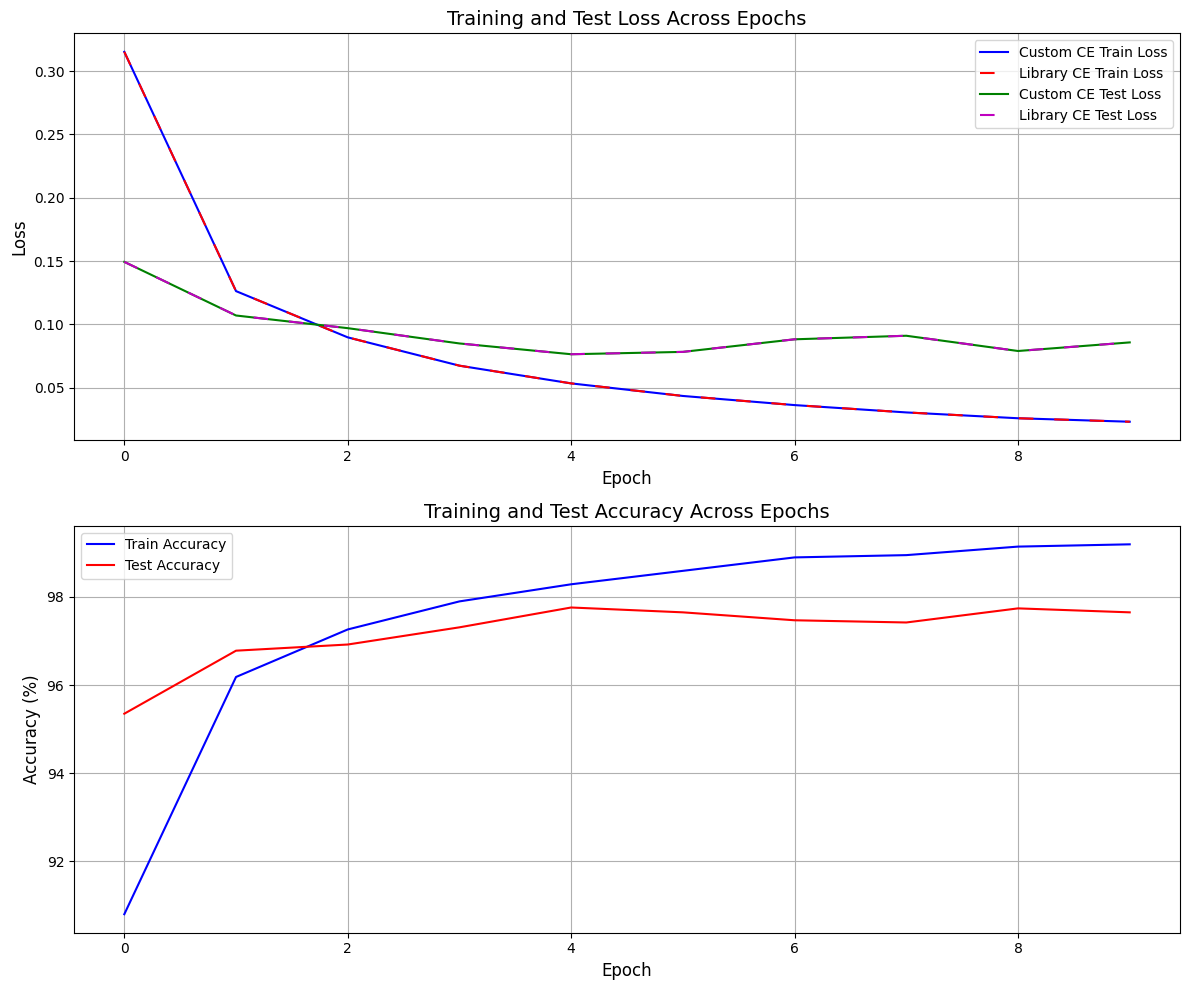

In [63]:
# Set up the figure with two subplots
plt.figure(figsize=(12, 10))

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Loss comparison
ax1.plot(history_float32['my_train_loss'], 'b-', label='Custom CE Train Loss')
ax1.plot(history_float32['ptrch_train_loss'], 'r--', label='Library CE Train Loss', dashes=(7,10))
ax1.plot(history_float32['my_test_loss'], 'g-', label='Custom CE Test Loss')
ax1.plot(history_float32['ptrch_test_loss'], 'm--', label='Library CE Test Loss', dashes=(7,10))
ax1.set_title('Training and Test Loss Across Epochs', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: Accuracy comparison
ax2.plot(history_float32['train_acc'], 'b-', label='Train Accuracy')
ax2.plot(history_float32['test_acc'], 'r-', label='Test Accuracy')
ax2.set_title('Training and Test Accuracy Across Epochs', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

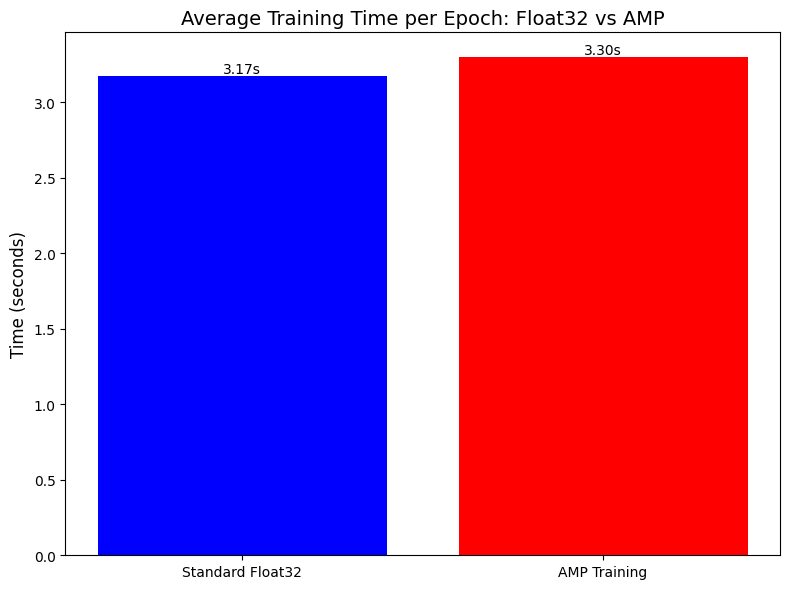

In [ ]:
avg_float32 = np.mean(history_float32['epoch_time'])
avg_amp = np.mean(history_amp['epoch_time'])

# Create bar chart
plt.figure(figsize=(8, 6))
methods = ['Standard Float32', 'AMP Training']
avg_times = [avg_float32, avg_amp]
bars = plt.bar(methods, avg_times, color=['blue', 'red'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s', ha='center', va='bottom')

# Add labels and title
plt.title('Average Training Time per Epoch: Float32 vs AMP', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()